#  Gastrointestinal Disease Classification with Deep Learning

Este proyecto entrena un modelo de aprendizaje profundo para clasificar imágenes médicas endoscópicas en tres clases: **pólipos, esofagitis y colitis ulcerativa**, usando el dataset Kvasir.

---

This project trains a deep learning model to classify endoscopic medical images into three classes: **polyps, esophagitis, and ulcerative colitis**, using the Kvasir dataset.


## Carga y preprocesamiento del dataset / Dataset Loading and Preprocessing

Se utilizaron generadores de imágenes con aumento de datos (`ImageDataGenerator`) para normalizar las imágenes y mejorar la generalización. Se dividió el conjunto de datos en entrenamiento (80%) y validación (20%).

---

Image generators with data augmentation (`ImageDataGenerator`) were used to normalize images and improve generalization. The dataset was split into training (80%) and validation (20%).


In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Importar librerías necesarias
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definir tamaño de imagen y batch
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Ruta del dataset (3 carpetas: polyp, esophagitis, ulcerative-colitis)
dataset_path = "/content/drive/MyDrive/Project"

# Generador con aumento de datos y normalización
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80% entrenamiento, 20% validación
)

# Generador de entrenamiento
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Generador de validación
val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


## Construcción del modelo inicial / Initial Model Construction

Se utilizó la arquitectura preentrenada **ResNet50** (transfer learning), congelando sus capas convolucionales y agregando nuevas capas densas con regularización y `dropout` para evitar sobreajuste.

---

The pretrained **ResNet50** architecture was used (transfer learning), freezing its convolutional layers and adding new dense layers with regularization and `dropout` to prevent overfitting.


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load base ResNet50 without top layers (include_top=False)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze the convolutional layers

# Final model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Dropout para evitar overfitting
    layers.Dense(3, activation='softmax')  # 3 clases
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callback: stop if no improvement
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


##  Entrenamiento con EarlyStopping / Training with EarlyStopping

El modelo se entrenó por varias épocas con `EarlyStopping`, deteniéndose si el `val_loss` no mejoraba tras 3 épocas. Se usó una función de pérdida categórica (`categorical_crossentropy`) adecuada para clasificación multiclase.

---

The model was trained over multiple epochs with `EarlyStopping`, stopping if `val_loss` did not improve for 3 epochs. The loss function was `categorical_crossentropy`, suitable for multi-class classification.


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop]
)


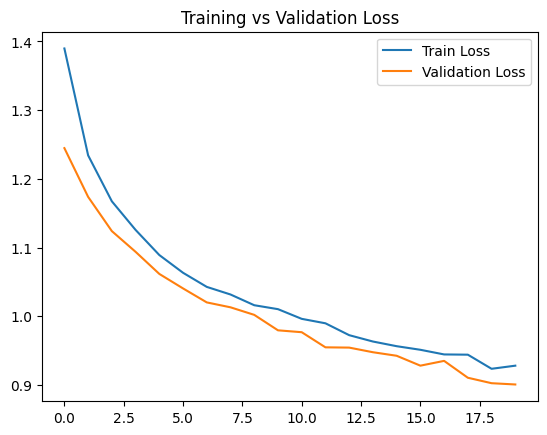

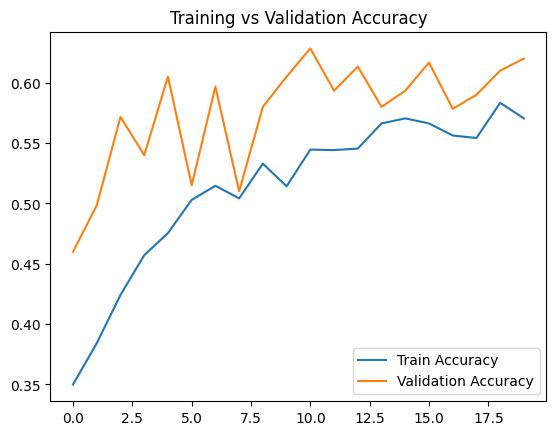

In [ ]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()


##  Fine-Tuning de ResNet50 / ResNet50 Fine-Tuning

Se desbloquearon las últimas 30 capas de ResNet50 para ajustar más finamente el modelo al dataset. Se recompiló el modelo con una tasa de aprendizaje más baja y se reentrenó algunas épocas más.

---

The last 30 layers of ResNet50 were unfrozen to better adapt the model to the dataset. The model was recompiled with a lower learning rate and trained for a few more epochs.


In [ ]:
# Unfreeze last layers of the base model
base_model.trainable = True

print("Total capas en ResNet50:", len(base_model.layers))

# Freeze all but the last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False


Total capas en ResNet50: 175


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


##  Guardado del modelo / Model Saving

El modelo final se guardó como archivo `.h5` para su reutilización futura.

---

The final model was saved as a `.h5` file for future reuse.


In [ ]:
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 766s 10s/step - accuracy: 0.5345 - loss: 0.8844 - val_accuracy: 0.6267 - val_loss: 0.8952
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 746s 10s/step - accuracy: 0.7344 - loss: 0.5813 - val_accuracy: 0.5183 - val_loss: 0.9327
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 781s 10s/step - accuracy: 0.7583 - loss: 0.5659 - val_accuracy: 0.7217 - val_loss: 0.7328
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 750s 10s/step - accuracy: 0.7889 - loss: 0.5077 - val_accuracy: 0.7133 - val_loss: 0.6493
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 766s 10s/step - accuracy: 0.7783 - loss: 0.5325 - val_accuracy: 0.7967 - val_loss: 0.4697
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 751s 10s/step - accuracy: 0.8166 - loss: 0.4603 - val_accuracy: 0.8367 - val_loss: 0.4651
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 756s 10s/step - accuracy: 0.8177 - loss: 0.4502 - val_accuracy: 0.7550 - val_loss: 0.6674
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 756s 10s/step - accuracy: 0.8481 - loss: 0.4214 - val_accuracy: 0.

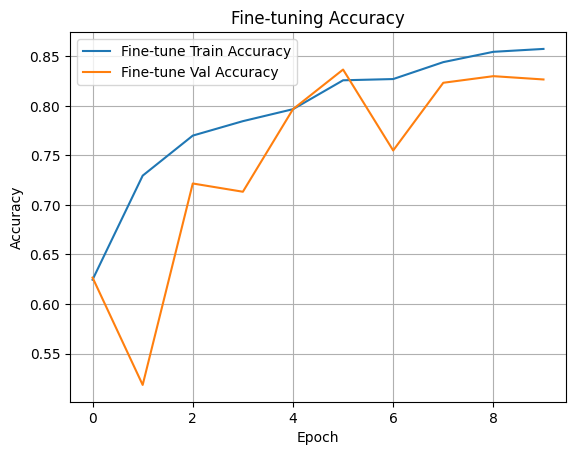

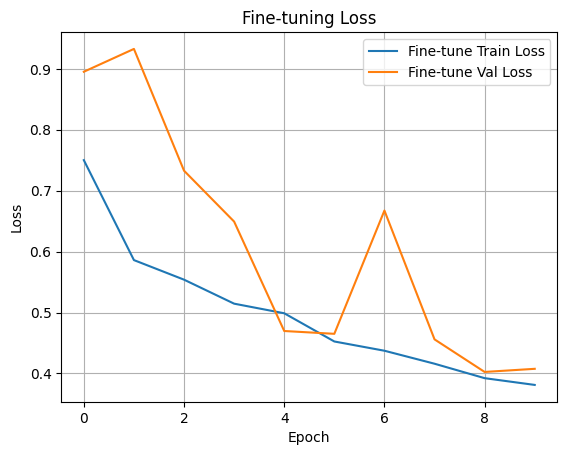

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history_finetune.history['accuracy'], label='Fine-tune Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Fine-tune Val Accuracy')
plt.title('Fine-tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_finetune.history['loss'], label='Fine-tune Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Fine-tune Val Loss')
plt.title('Fine-tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/Project/modelo_polyps_final.h5')


19/19 ━━━━━━━━━━━━━━━━━━━━ 123s 6s/step


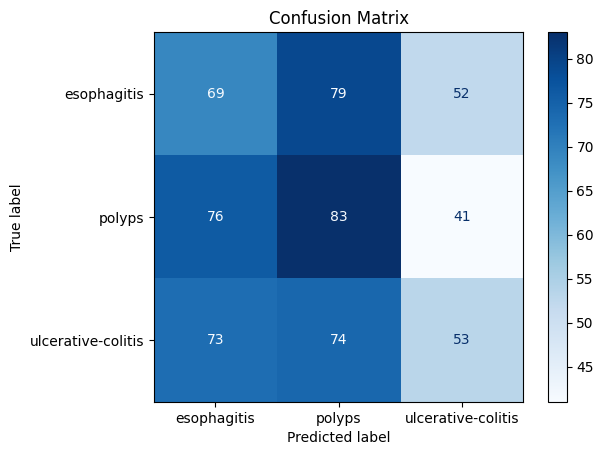

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

val_generator.reset()
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred)
labels = list(val_generator.class_indices.keys())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


Saving Test2.jpg to Test2 (1).jpg


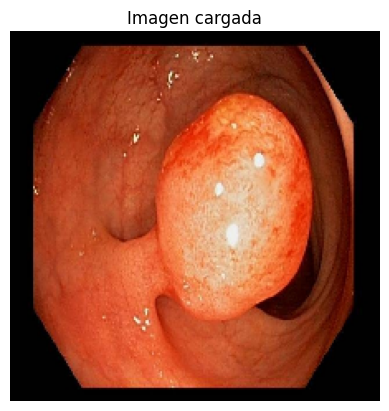

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicción: polyps (84.61%)


In [13]:
from google.colab import files
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Reemplaza esto si tu archivo tiene otro nombre
from tensorflow.keras.models import load_model

ruta_modelo = "/content/drive/MyDrive/Diego Flores/Project/modelo_polyps_final.h5"
modelo = load_model(ruta_modelo)


# Subir imágenes desde la computadora
uploaded = files.upload()

# Diccionario de clases
clases = {0: 'esophagitis', 1: 'polyps', 2: 'ulcerative-colitis'}

# Predecir cada imagen subida
for nombre_archivo in uploaded.keys():
    img = image.load_img(nombre_archivo, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Mostrar imagen
    plt.imshow(img)
    plt.title("Imagen cargada")
    plt.axis('off')
    plt.show()

    # Predecir
    pred = modelo.predict(img_array)
    clase = np.argmax(pred)
    print(f"Predicción: {clases[clase]} ({pred[0][clase]*100:.2f}%)")
